In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

In [2]:
training_data = datasets.FashionMNIST(
    root = "data", # the path where the train/test data is stored
    train = True,  # specifies training or test dataset
    download = True, #  downloads the data from the internet if it’s not available at root
    transform = ToTensor(),) # specify the feature and label transformations

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor(),)

C:\Users\syjy0\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# The FashionMNIST features are in PIL Image format, and the labels are integers. 
# For training, we need the features as normalized tensors, and the labels as one-hot encoded tensors. 
# To make these transformations, we use ToTensor and Lambda.
# Lambda:
- define a function to turn the integer into a one-hot encoded tensor
- target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))

# ToTensor: 
- convert a PIL image or NumPy ndarray into a FloatTensor. and scales the image’s pixel intensity values in the range [0., 1.].

In [20]:
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size = batch_size )#shuffle = True(Default)
test_dataloader = DataLoader(test_data, batch_size = batch_size, shuffle = True)

for X,y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


# Creating Models

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


# Define the Class
- We define our neural network by subclassing nn.Module, and initialize the neural network layers in __init__. Every nn.Module subclass implements the operations on input data in the forward method.

In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)

# Train: loop over our optimization code

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropatation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d} / {size:>5d}]")

# Test: evaluate the model's performance against our test data

In [7]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>7f} \n")

In [8]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1} \n ---------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1 
 ---------------------------
loss: 2.307667  [    0 / 60000]
loss: 2.298501  [ 6400 / 60000]
loss: 2.294166  [12800 / 60000]
loss: 2.295563  [19200 / 60000]
loss: 2.287376  [25600 / 60000]
loss: 2.279513  [32000 / 60000]
loss: 2.282478  [38400 / 60000]
loss: 2.267565  [44800 / 60000]
loss: 2.285837  [51200 / 60000]
loss: 2.265266  [57600 / 60000]
Test Error: 
 Accuracy: 21.1%, Avg loss: 2.267880 

Epoch 2 
 ---------------------------
loss: 2.267700  [    0 / 60000]
loss: 2.268491  [ 6400 / 60000]
loss: 2.246264  [12800 / 60000]
loss: 2.264539  [19200 / 60000]
loss: 2.237208  [25600 / 60000]
loss: 2.198183  [32000 / 60000]
loss: 2.238669  [38400 / 60000]
loss: 2.191026  [44800 / 60000]
loss: 2.231582  [51200 / 60000]
loss: 2.179361  [57600 / 60000]
Test Error: 
 Accuracy: 22.8%, Avg loss: 2.194735 

Epoch 3 
 ---------------------------
loss: 2.198578  [    0 / 60000]
loss: 2.204520  [ 6400 / 60000]
loss: 2.159516  [12800 / 60000]
loss: 2.214625  [19200 / 60000]
loss: 2.121284

# Saving Models

In [9]:
torch.save(model.state_dict(), "model.pth")

# Loading Models

In [10]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

classes = [
     "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
model.eval()
x,y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


# Iterating and Visualizing the Dataset

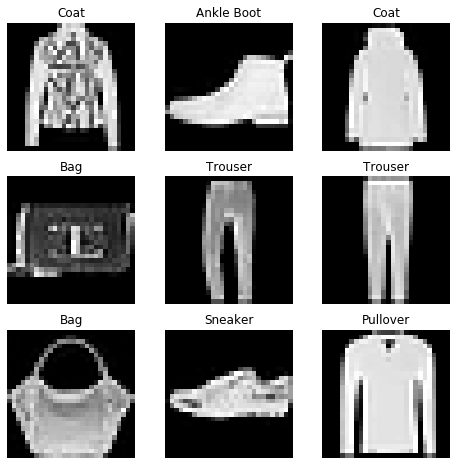

In [17]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, cols * rows +1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()